In [9]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.signal import medfilt
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from tqdm import tqdm
import warnings
from IPython.display import Image, Audio, display
from ipywidgets import widgets

warnings.filterwarnings('ignore')

In [10]:
# Função para extrair características de áudio
def extract_features(audio_data, sample_rate, mfcc=True, chroma=True, mel=True, spectral_centroid=True, zero_crossing_rate=True):
        features = []
        
        # Calcular a média da amplitude do sinal de áudio
        amplitude_mean = np.mean(np.abs(audio_data))
        features.append(amplitude_mean)
        
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            features.extend(mfccs)
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(y=audio_data, sr=sample_rate).T,axis=0)
            features.extend(chroma)
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=audio_data, sr=sample_rate).T,axis=0)
            features.extend(mel)
        if spectral_centroid:
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_data, sr=sample_rate)[0])
            features.append(spectral_centroid)
        if zero_crossing_rate:
            zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio_data))
            features.append(zero_crossing_rate)
            
        return features

# Diretório onde os arquivos de áudio estão localizados
audio_dir = "MP3"

# Lista para armazenar as características extraídas
features = []

# Lista para armazenar os nomes dos arquivos de áudio válidos
audio_files = []

# Extrair características de cada arquivo de áudio na pasta
for file_name in os.listdir(audio_dir):
    if file_name.endswith(".mp3"):
        # Carregar o áudio usando librosa
        audio_data, sample_rate = librosa.load(os.path.join(audio_dir, file_name))

        # Extrair características do áudio
        features.append(extract_features(audio_data, sample_rate))


# Convertendo a lista de características para uma matriz numpy
features = np.array(features)
print(features)

[[ 2.82559656e-02 -3.57475494e+02  1.44278671e+02 ...  4.16022249e-06
   1.50232086e+03  6.08282574e-02]
 [ 5.79456165e-02 -3.62867981e+02  1.13480652e+02 ...  2.81965913e-06
   1.84096022e+03  8.56782699e-02]
 [ 1.74287818e-02 -3.74741486e+02  1.28402176e+02 ...  2.24341238e-06
   1.87077334e+03  7.87385360e-02]
 ...
 [ 1.11866057e-01 -1.49723373e+02  1.98960831e+02 ...  2.88329873e-04
   1.10294515e+03  6.74756512e-02]
 [ 3.38188857e-02 -2.22196304e+02  1.61071274e+02 ...  9.62356808e-06
   1.43517457e+03  9.27903451e-02]
 [ 1.43012881e-01 -1.48891693e+02  1.65103821e+02 ...  9.46412270e-04
   1.43657138e+03  6.68424881e-02]]


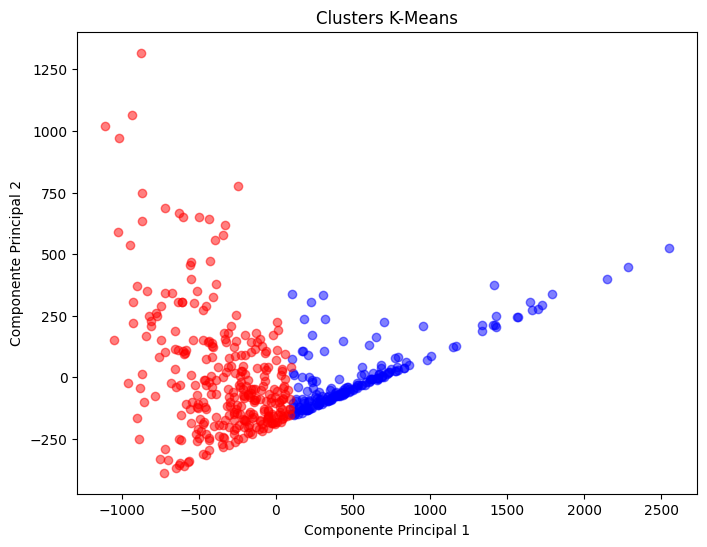

Método não supervisionado:
Acurácia : 0.44693877551020406
F1 Score: 0.440167145687585


In [11]:
# MÉTODO NÃO SUPERVISIONADO (K-MEANS)
# Aplicar K-Means para agrupar os dados
kmeans = KMeans(n_clusters=2)  # número de clusters pode ser ajustado
kmeans.fit(features)

# Rotular os clusters
labels = kmeans.labels_

# Identificar os arquivos de áudio que são identificados como áudios válidos
audio_files_indices = np.where(labels == 1)[0]

# Exibir os arquivos de áudio que são identificados como outliers
# print("Deglutições detectadas nos seguintes arquivos (K-Means):")
# for idx in audio_files_indices:
#     audio_files.append(os.path.join(audio_dir, os.listdir(audio_dir)[idx]))
#     print(os.listdir(audio_dir)[idx])

# Aplicar PCA para reduzir a dimensionalidade dos dados para visualização
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# Plotar os clusters
plt.figure(figsize=(8, 6))
for i in range(len(features_pca)):
    if labels[i] == 0:
        plt.scatter(features_pca[i, 0], features_pca[i, 1], color='blue', alpha=0.5)
    else:
        plt.scatter(features_pca[i, 0], features_pca[i, 1], color='red', alpha=0.5)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters K-Means')
plt.show()

# Identificando true labels
tutor = pd.read_csv('classificacao_anomalias.csv')
tutor = tutor[['File Name','Label']]
tutor['Label'] = tutor['Label'].apply(lambda x: 1 if x == 0 else 0)
true_labels = tutor['Label'].values

# Calcular a acurácia
accuracy = accuracy_score(true_labels, labels)

# Calcular a pontuação F1
f1 = f1_score(true_labels, labels, average='weighted')

# Printando Acurácia e F1 Score
print("Método não supervisionado:")
print("Acurácia :", accuracy)
print("F1 Score:", f1)

In [12]:
# Comparando classificadores de aprendizado supervisionado com validação cruzada
classificadores = [
    DecisionTreeClassifier(random_state=42,max_depth=5),
    ExtraTreeClassifier(random_state=42,max_depth=5),
    RandomForestClassifier(random_state=42,max_depth=5),
    ExtraTreesClassifier(random_state=42,max_depth=5),
    GradientBoostingClassifier(random_state=42,max_depth=5),
    AdaBoostClassifier(random_state=42),
    HistGradientBoostingClassifier(random_state=42,max_depth=5),
    LogisticRegression(random_state=42),
]

resultados = []
for cls in tqdm(classificadores):
    res = cross_validate(cls, features, true_labels, cv=5, scoring='f1')
    resultados.append(
        {'metodo': cls.__class__.__name__, 
         'f1': res['test_score'].mean(), 
         'tempo': res['fit_time'].mean(),
         }
    )

warnings.filterwarnings('default')
df_res = pd.DataFrame(resultados)
df_res.sort_values('f1', ascending=False)
print(df_res)

# # MÉTODO SUPERVISIONADO (Random Forest Classifier)
# # Instanciar um objeto RandomForestClassifier
random_forest = RandomForestClassifier(random_state=42, max_depth=5)

# # Ajustar o modelo aos dados de treinamento
random_forest.fit(features, true_labels)

# # F1 Score do modelo
f1_rfc = random_forest.score(features, true_labels)

print("\nMétodo supervisionado:")
print("F1 Score:", f1_rfc)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:08<00:00,  8.58s/it]


                           metodo        f1      tempo
0          DecisionTreeClassifier  0.497981   0.085764
1             ExtraTreeClassifier  0.597540   0.003785
2          RandomForestClassifier  0.561205   0.620687
3            ExtraTreesClassifier  0.572033   0.107733
4      GradientBoostingClassifier  0.451193  11.133424
5              AdaBoostClassifier  0.512648   1.242472
6  HistGradientBoostingClassifier  0.455892   0.460170
7              LogisticRegression  0.473741   0.026825

Método supervisionado:
F1 Score: 0.8551020408163266


In [14]:
# Juntar o dataframe tutor e o array features em um único dataframe
df = pd.DataFrame(features, columns=["Feature_" + str(i) for i in range(features.shape[1])])
df = pd.concat([tutor, df], axis=1)
df.reset_index(inplace=True)

blocos = []
for i, row in df.head(50).iterrows():
    nome = row['File Name'].split('.')[0]
    out = widgets.Output()
    with out:
        display(Image(f'Charts/{nome}.png'))
        display('Inválido' if row['Label'] == 0 else 'Válido')
        display(Audio(f'MP3/{nome}.mp3'))
    blocos.append(out)
widgets.HBox(blocos)